# Demo: Monitoring Train and Validation Loss During Model Training

Loss curves are your model's vital signs: two simple lines on a graph that reveal whether your model is learning real patterns, memorizing noise, or struggling to train at all. But knowing what these patterns mean in theory and diagnosing them in practice are two different skills.

> **Overview**: We'll train neural networks on forest cover classification and watch their loss curves unfold in real-time. By plotting training and validation loss side by side, we'll see exactly how different model capacities lead to underfitting, good fit, and overfitting.
> 
> **Scenario**: Your forest conservation agency built a classifier that perfectly identifies tree cover types in training regions but fails catastrophically on new wilderness areas. The model memorized specific GPS coordinates and elevation patterns instead of learning generalizable vegetation features. How could you have caught this during training? Loss curves would have shown the warning signs immediately.
> 
> **Goal**: Learn to read loss curves like an expert: quickly spotting the divergence point where validation loss stops improving, identifying the sweet spot where your model generalizes best, and understanding when to stop training.
> 
> **Tools**: Python, PyTorch, NumPy, Matplotlib

## Step 1: Setup

Let's start by importing our libraries and setting up our environment.

In [1]:
# Import core libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from datasets import load_from_disk
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import os
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Create output directory for visualizations
output_dir = 'assets/demo8'
os.makedirs(output_dir, exist_ok=True)

# Check device availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print("Setup complete!\n")

Using device: cuda
Setup complete!



## Step 2: Load and prepare the dataset

We'll use the [mstz/covertype](https://huggingface.co/datasets/mstz/covertype) dataset, which contains over 580,000 forest observations from Roosevelt National Forest in Colorado. Each observation includes 54 cartographic features (elevation, slope, distance to water, soil type, etc.) and a label indicating which of 7 tree species dominates that 30m × 30m patch.

For preprocessing, we'll:
1. Load the dataset and convert to pandas
2. Subset data (for faster experimentation)
3. Separate features from labels
4. Normalize features to help training
5. Split into train/validation/test sets
6. Convert to PyTorch datasets
7. Create DataLoaders

**IMPORTANT: Feel free to skip this section to focus on the loss curves themselves**. Just know that we end up with ~10k training examples, ~5k validation examples, and ~5k test examples, each with 54 normalized features predicting one of 7 forest cover types (with class ids 0:6).

In [2]:
# 1. Load the dataset
print("Loading Forest Cover Type dataset...")
try:
    dataset = load_from_disk("/workspace/data/covertype-arrow")
except:
    print(f"⚠︎ Local load failed ({err})). Will need to fall back to the Hugging Face Hub (may take 3-4 minutes)")
    dataset = load_dataset(
        "mstz/covertype",
        split="train",
        revision="refs/convert/parquet"
    )

df = dataset.to_pandas()
print(f"✓ Dataset loaded: {len(df):,} samples\n")

# 2. Subset data for faster training (still large enough for clear patterns)
subset_size = 20000
df = df.sample(n=subset_size, random_state=42).reset_index(drop=True)
print(f"✓ Using subset: {len(df):,} samples for faster demo\n")

# 3. Separate features and labels
# Labels are 1-7, convert to 0-6 for PyTorch
y = df['cover_type'].values
X = df.drop('cover_type', axis=1).values.astype(np.float64)

print(f"Features shape: {X.shape}")
print(f"Labels shape: {y.shape}")
print(f"Number of classes: {df['cover_type'].nunique()}")
print(f"Class distribution:\n{df['cover_type'].value_counts().sort_index()}\n")

# 4. Normalize features (important for stable training)
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)
print("✓ Features normalized\n")

# 5. Split into train/val/test (50% train, 25% val, 25% test)
X_temp, X_test, y_temp, y_test = train_test_split(
    X_normalized, y, test_size=0.25, random_state=42, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.333, random_state=42, stratify=y_temp  # 0.333 of 75% = 25% of total
)

print(f"✓ Data split:")
print(f"  Training: {len(X_train):,} samples")
print(f"  Validation: {len(X_val):,} samples")
print(f"  Test: {len(X_test):,} samples\n")

# 6. Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.LongTensor(y_train)
X_val_tensor = torch.FloatTensor(X_val)
y_val_tensor = torch.LongTensor(y_val)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.LongTensor(y_test)

# Create datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

# 7. Create DataLoaders
batch_size = 256
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(f"✓ DataLoaders created with batch size {batch_size}")
print(f"  Training batches per epoch: {len(train_loader)}")
print(f"  Validation batches: {len(val_loader)}")

Loading Forest Cover Type dataset...
✓ Dataset loaded: 581,012 samples

✓ Using subset: 20,000 samples for faster demo

Features shape: (20000, 54)
Labels shape: (20000,)
Number of classes: 7
Class distribution:
cover_type
0    7365
1    9725
2    1207
3      85
4     317
5     627
6     674
Name: count, dtype: int64

✓ Features normalized

✓ Data split:
  Training: 10,005 samples
  Validation: 4,995 samples
  Test: 5,000 samples

✓ DataLoaders created with batch size 256
  Training batches per epoch: 40
  Validation batches: 20


> **Why three splits?** We divide our data into three distinct sets, each with a specific purpose:
> 
> - **Training set (50%)**: The data the model learns from. The model sees these examples during backpropagation and updates its weights to minimize loss on this set.
> - **Validation set (25%)**: Held-out data used to monitor generalization during training. The model never learns from these examples—we only use them to check if the patterns learned on training data transfer to unseen data. This is what lets us detect overfitting.
> - **Test set (25%)**: Completely untouched data reserved for final evaluation. We don't look at this until training is complete. This gives us an unbiased estimate of real-world performance.
> 
> The key principle: Validation guides training decisions (when to stop, which model to pick), while test measures final performance. Using `stratify=y` ensures each split maintains the same proportion of forest cover types, preventing scenarios where rare classes end up only in one set.

## Step 3: Define and train three models

Now we'll create three models with different capacities and train them all. We'll track both training and validation loss at every epoch so we can diagnose their behavior.

**The three models:**
- **Underfit model**: Too simple (4 hidden neurons) to capture forest patterns
- **Good fit model**: Just right (64 hidden neurons) to learn generalizable features  
- **Overfit model**: Too complex (512 hidden neurons) with tendency to memorize

This will take 2-3 minutes with GPU. Watch the printed losses: you might already spot patterns before we plot them!


### 3.1: Instantiate models

We'll create three identical architectures (one hidden layer) with different widths. 

The only difference is the number of neurons in the hidden layer: this single parameter determines whether a model underfits, fits well, or overfits.

In [3]:
# Create the model class

class ForestClassifier(nn.Module):
    """Simple feedforward network for forest cover classification."""
    
    def __init__(self, input_size=54, hidden_size=64, num_classes=7):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, num_classes)
        )
    
    def forward(self, x):
        return self.network(x)

# Create three models with different capacities
model_underfit = ForestClassifier(hidden_size=4).to(device)
model_goodfit = ForestClassifier(hidden_size=64).to(device)
model_overfit = ForestClassifier(hidden_size=512).to(device)

print("✓ Three models created:")
print(f"  Underfit model: {sum(p.numel() for p in model_underfit.parameters()):,} parameters")
print(f"  Good fit model: {sum(p.numel() for p in model_goodfit.parameters()):,} parameters")
print(f"  Overfit model: {sum(p.numel() for p in model_overfit.parameters()):,} parameters")

✓ Three models created:
  Underfit model: 255 parameters
  Good fit model: 3,975 parameters
  Overfit model: 31,751 parameters


> **Model capacity matters**: 
> - The *underfit* model has only 255 parameters. These are too few to capture the complex relationships between 54 input features and 7 forest types.
> - The *overfit* model has 31,751 parameters. These are so many that it can memorize training examples instead of learning patterns. 
> - The *good fit* model sits at 3,975 parameters. This is enough capacity to learn without excessive memorization. Watch how these parameter counts translate directly to loss curve behavior.

### 3.2: Define training function

Before we train, we need a function that not only trains the model but also tracks both training and validation loss at every epoch. This tracking is what makes loss curve diagnosis possible—without it, you're flying blind.

In [4]:
# Define the training function
def train_and_track(model, train_loader, val_loader, epochs=50, lr=0.001):
    """
    Train a model and track both training and validation losses.
    
    Returns:
        train_losses: List of average training loss per epoch
        val_losses: List of validation loss per epoch
    """
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss_sum = 0.0
        train_batches = 0
        
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            # Forward pass
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss_sum += loss.item()
            train_batches += 1
        
        # Calculate average training loss for this epoch
        avg_train_loss = train_loss_sum / train_batches
        train_losses.append(avg_train_loss)
        
        # Validation phase
        model.eval()
        val_loss_sum = 0.0
        val_batches = 0
        
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_loss_sum += loss.item()
                val_batches += 1
        
        # Calculate validation loss for this epoch
        avg_val_loss = val_loss_sum / val_batches
        val_losses.append(avg_val_loss)
        
        # Print progress every 10 epochs
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")
    
    return train_losses, val_losses

print("✓ Training function defined")

✓ Training function defined


> **The importance of tracking both losses**: Notice how we compute validation loss after every epoch during training. This isn't just for evaluation: it's diagnostic data. By comparing training loss (how well the model fits the data it's learning from) to validation loss (how well it generalizes to unseen data), we can detect overfitting the moment it begins. 
> 
> This is the foundation of knowing when to stop training and which model checkpoint to keep.

### 3.3: Train all three models

Time to train! We'll run all three models for 250 epochs and capture their complete loss histories. 

Pay attention to the printed losses: you might already notice the underfit model stuck high, the good fit model improving steadily, and the overfit model's validation loss starting to rise.

> **NOTE**: The learning rate was tuned slightly for stability with the different architecture sizes.

In [5]:
# Train the three models
epochs = 250
learning_rate = 0.001

print("=" * 60)
print("Training UNDERFIT model (4 hidden neurons)")
print("=" * 60)
train_losses_underfit, val_losses_underfit = train_and_track(
    model_underfit, train_loader, val_loader, epochs=epochs, lr=learning_rate
)

print("\n" + "=" * 60)
print("Training GOOD FIT model (64 hidden neurons)")
print("=" * 60)
train_losses_goodfit, val_losses_goodfit = train_and_track(
    model_goodfit, train_loader, val_loader, epochs=epochs, lr=learning_rate
)

print("\n" + "=" * 60)
print("Training OVERFIT model (512 hidden neurons)")
print("=" * 60)
train_losses_overfit, val_losses_overfit = train_and_track(
    model_overfit, train_loader, val_loader, epochs=epochs, lr=learning_rate
)

print("\n✓ All models trained!")

Training UNDERFIT model (4 hidden neurons)
Epoch 10/250 | Train Loss: 0.9594 | Val Loss: 0.9658
Epoch 20/250 | Train Loss: 0.8430 | Val Loss: 0.8624
Epoch 30/250 | Train Loss: 0.7866 | Val Loss: 0.7982
Epoch 40/250 | Train Loss: 0.7418 | Val Loss: 0.7646
Epoch 50/250 | Train Loss: 0.7133 | Val Loss: 0.7419
Epoch 60/250 | Train Loss: 0.7046 | Val Loss: 0.7263
Epoch 70/250 | Train Loss: 0.6895 | Val Loss: 0.7142
Epoch 80/250 | Train Loss: 0.6779 | Val Loss: 0.7091
Epoch 90/250 | Train Loss: 0.6725 | Val Loss: 0.7061
Epoch 100/250 | Train Loss: 0.6716 | Val Loss: 0.7045
Epoch 110/250 | Train Loss: 0.6754 | Val Loss: 0.7014
Epoch 120/250 | Train Loss: 0.6705 | Val Loss: 0.6985
Epoch 130/250 | Train Loss: 0.6706 | Val Loss: 0.6966
Epoch 140/250 | Train Loss: 0.6704 | Val Loss: 0.6950
Epoch 150/250 | Train Loss: 0.6640 | Val Loss: 0.6929
Epoch 160/250 | Train Loss: 0.6639 | Val Loss: 0.6921
Epoch 170/250 | Train Loss: 0.6659 | Val Loss: 0.6916
Epoch 180/250 | Train Loss: 0.6625 | Val Loss: 0

> **What you're seeing in the numbers**: Look closely at the printed losses. 
> - The *underfit model*'s losses barely budge, both training and validation stay high. 
> - The *good fit model* shows both losses dropping together smoothly. 
> - The *overfit model*'s training loss plummets toward zero while validation loss plateaus or even rises. 
> 
> These numerical patterns are exactly what we'll see visualized in the plots.

## Step 4: Diagnose model behavior with loss curves

Now comes the critical skill: reading loss curves to diagnose what went wrong (or right). 

We'll plot all three models side-by-side to see the three classic patterns, then annotate the overfit model to show exactly where training should have stopped.

### 4.1: Plot training loss only (The naive view)

Let's start by making a common beginner mistake: only plotting training loss. When you look at just the training curve, everything seems great! The loss drops smoothly toward zero. Mission accomplished, right?

Wrong. This is why training loss alone is dangerously misleading.

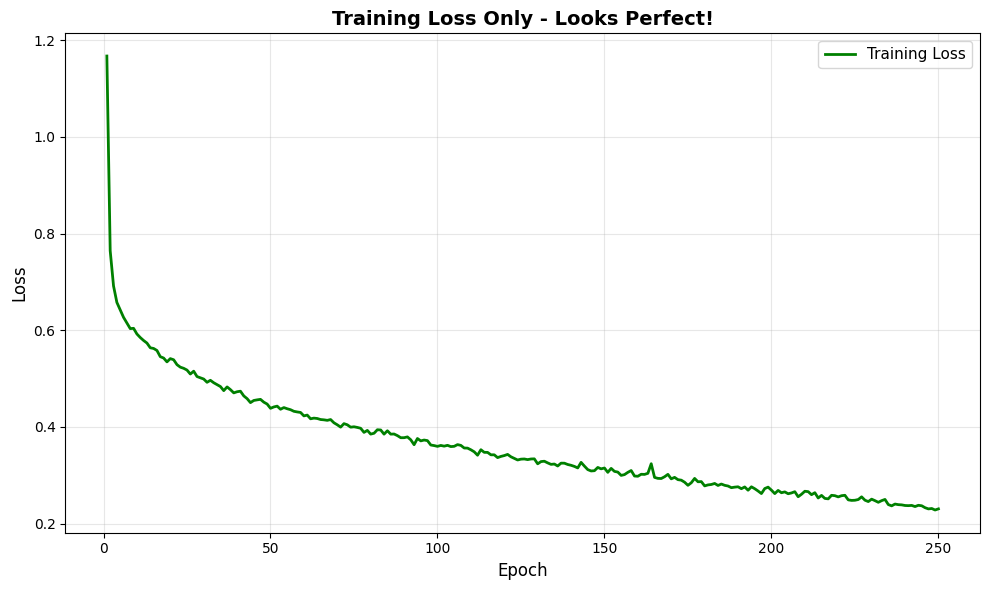

Final training loss: 0.2305

⚠︎  This looks amazing! Loss approaching zero = perfect model, right?
⚠︎  WRONG. You can't tell if the model generalizes from training loss alone.


In [6]:
# Plot only training loss for the overfit model
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_losses_overfit, 'g-', linewidth=2, label='Training Loss')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training Loss Only - Looks Perfect!', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'naive_view.png'), dpi=300, bbox_inches='tight')
plt.show()

print(f"Final training loss: {train_losses_overfit[-1]:.4f}")
print("\n⚠︎  This looks amazing! Loss approaching zero = perfect model, right?")
print("⚠︎  WRONG. You can't tell if the model generalizes from training loss alone.")

> **The illusion of success**: A model can achieve near-zero training loss by simply memorizing every training example. It's like a student who memorizes answers to practice problems but can't solve new ones. The training curve can't reveal this—it only shows how well the model fits the data it's learning from, not whether it understands the underlying patterns. This is why validation loss is non-negotiable.

### 4.2 Add validation loss (The complete view)

Now let's add validation loss to the same plot. This is where the truth emerges. The validation curve reveals what the training curve hides: this model is memorizing, not learning.

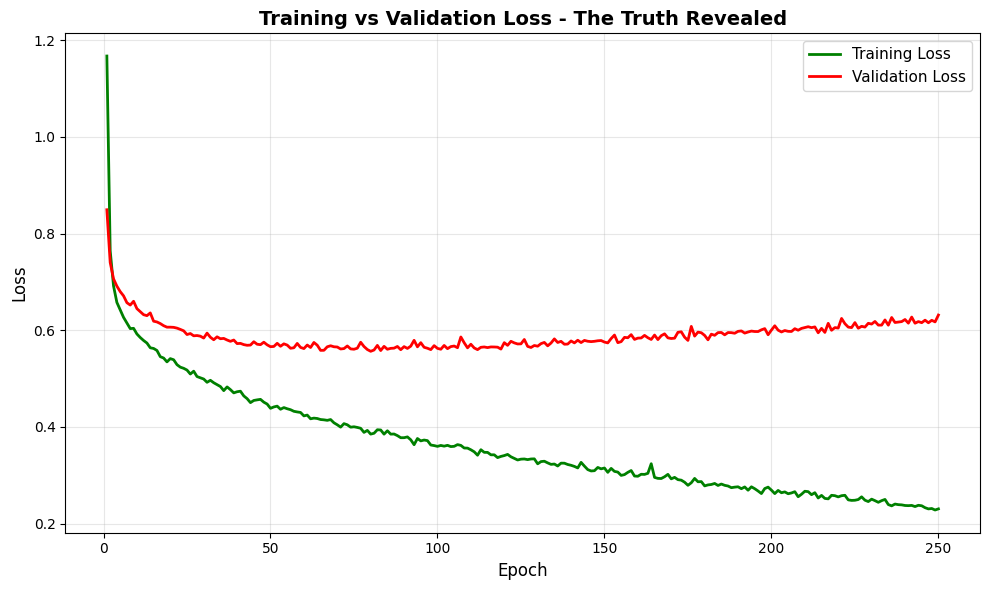

Final training loss: 0.2305
Final validation loss: 0.6314
Gap: 0.4009

⚠︎  The gap reveals the problem: model memorizes training data!


In [7]:
# Plot both training and validation loss for the overfit model
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_losses_overfit, 'g-', linewidth=2, label='Training Loss')
plt.plot(range(1, epochs + 1), val_losses_overfit, 'r-', linewidth=2, label='Validation Loss')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training vs Validation Loss - The Truth Revealed', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'revealing_view.png'), dpi=300, bbox_inches='tight')
plt.show()

print(f"Final training loss: {train_losses_overfit[-1]:.4f}")
print(f"Final validation loss: {val_losses_overfit[-1]:.4f}")
print(f"Gap: {val_losses_overfit[-1] - train_losses_overfit[-1]:.4f}")
print("\n⚠︎  The gap reveals the problem: model memorizes training data!")

> **The divergence tells the story**: Watch how the curves move together initially—both dropping as the model learns basic patterns. Then they split apart. Training loss continues falling (the model keeps getting better at fitting training examples), but validation loss plateaus or rises (the model stops generalizing). 
> 
> The growing gap between them is your warning sign: you've crossed from learning into memorization territory.

#### (EXTRA) Annotate the overfitting curves

Let's make the diagnostic insight even clearer by annotating the three zones that appear in overfitting curves:

1. **Underfitting zone** (early epochs): Both losses are high; model hasn't learned much yet
2. **Sweet spot** (middle epochs): Both losses drop together; model is learning generalizable patterns
3. **Overfitting zone** (late epochs): Training loss keeps dropping, validation loss rises; model is memorizing

The boundary between zones 2 and 3 is where you should have stopped training.

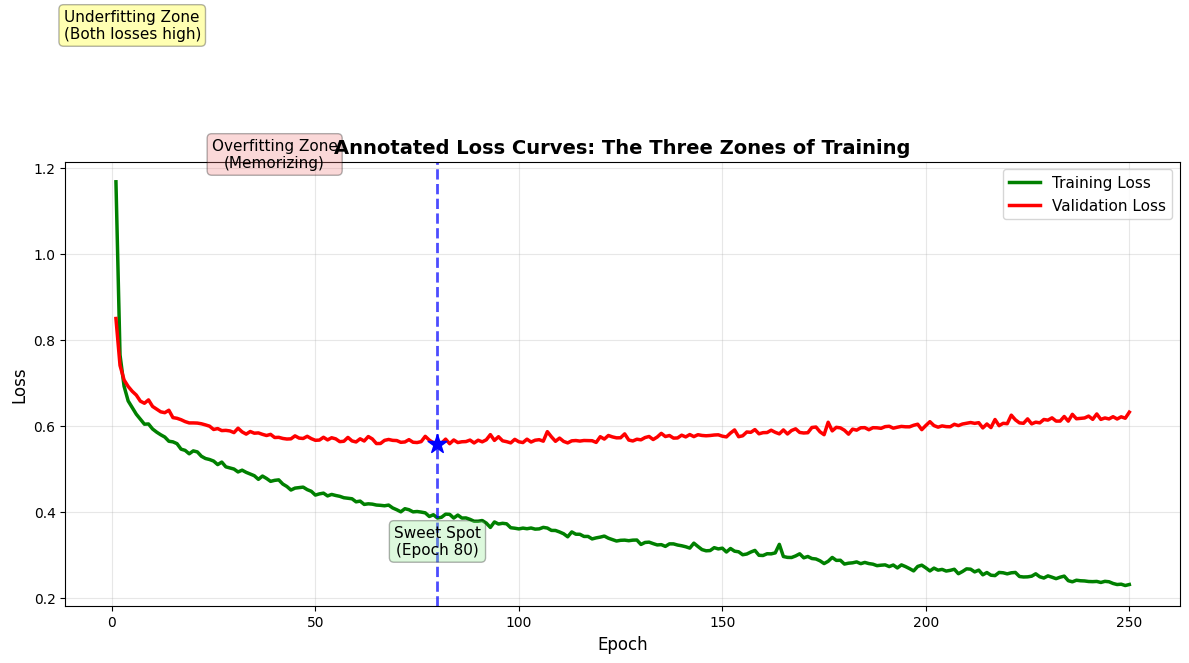

✓ Best validation loss: 0.5564 at epoch 80
✓ Training loss at epoch 80: 0.3852
✓ Final training loss (epoch 250): 0.2305
✓ Final validation loss (epoch 250): 0.6314

  Key insight: We should have stopped at epoch 80, not epoch 250!


In [8]:
# Find the epoch where validation loss is minimum (the "sweet spot")
best_epoch = np.argmin(val_losses_overfit) + 1
best_val_loss = val_losses_overfit[best_epoch - 1]

# Create annotated plot
plt.figure(figsize=(12, 7))

# Plot the curves
plt.plot(range(1, epochs + 1), train_losses_overfit, 'g-', linewidth=2.5, label='Training Loss')
plt.plot(range(1, epochs + 1), val_losses_overfit, 'r-', linewidth=2.5, label='Validation Loss')

# Mark the sweet spot
plt.axvline(x=best_epoch, color='blue', linestyle='--', linewidth=2, alpha=0.7)
plt.scatter([best_epoch], [best_val_loss], color='blue', s=200, zorder=5, marker='*')

# Add zone annotations
plt.text(5, 1.5, 'Underfitting Zone\n(Both losses high)', 
         fontsize=11, ha='center', bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.3))
plt.text(best_epoch, 0.3, f'Sweet Spot\n(Epoch {best_epoch})', 
         fontsize=11, ha='center', bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.3))
plt.text(40, 1.2, 'Overfitting Zone\n(Memorizing)', 
         fontsize=11, ha='center', bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.3))

plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Annotated Loss Curves: The Three Zones of Training', fontsize=14, fontweight='bold')
plt.legend(fontsize=11, loc='upper right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'annotated_zones.png'), dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Best validation loss: {best_val_loss:.4f} at epoch {best_epoch}")
print(f"✓ Training loss at epoch {best_epoch}: {train_losses_overfit[best_epoch-1]:.4f}")
print(f"✓ Final training loss (epoch {epochs}): {train_losses_overfit[-1]:.4f}")
print(f"✓ Final validation loss (epoch {epochs}): {val_losses_overfit[-1]:.4f}")
print(f"\n  Key insight: We should have stopped at epoch {best_epoch}, not epoch {epochs}!")

> **Finding the sweet spot**: The blue star marks the epoch where validation loss reaches its minimum. This is your model's peak generalization point, the moment where it has learned the most useful patterns without memorizing noise. After this point, every additional epoch of training improves training loss (memorization) at the expense of validation loss (generalization). 
> 
> This is why you should monitor validation loss to decide when to stop training your model, and save the model at that exact moment.

### 4.3: Compare all three models side-by-side

Now for the grand finale: let's compare all three models side-by-side. You'll see the three classic loss curve patterns that correspond to underfitting, good fit, and overfitting. This is pattern recognition training: learning to glance at curves and immediately diagnose the problem.

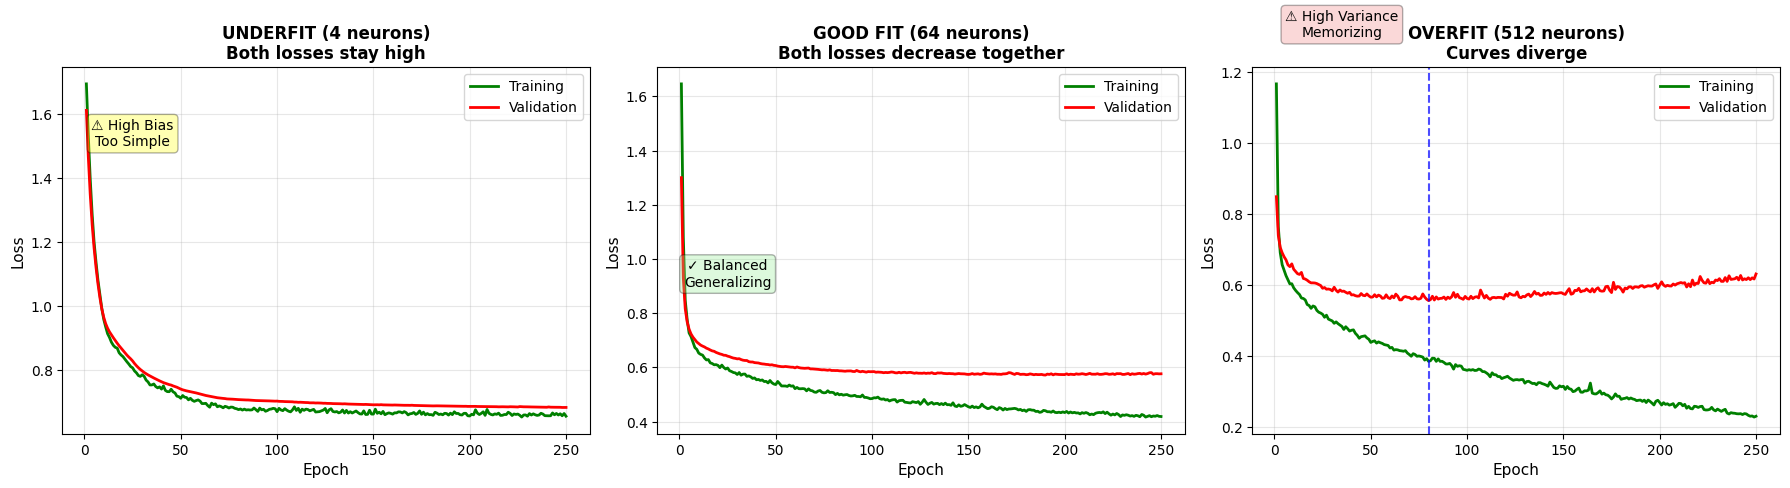


MODEL COMPARISON SUMMARY

UNDERFIT (4 neurons):
  Final train loss: 0.6575
  Final val loss:   0.6847
  Gap:              0.0273
  Diagnosis: ⚠︎  Both losses stuck high → Need more capacity

GOOD FIT (64 neurons):
  Final train loss: 0.4191
  Final val loss:   0.5767
  Gap:              0.1576
  Diagnosis: ✓ Losses move together → Healthy generalization

OVERFIT (512 neurons):
  Final train loss: 0.2305
  Final val loss:   0.6314
  Gap:              0.4009
  Best epoch:       80 (val loss: 0.5564)
  Diagnosis: ⚠︎  Curves diverge → Stop at epoch 80 or add regularization


In [9]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Underfit model
axes[0].plot(range(1, epochs + 1), train_losses_underfit, 'g-', linewidth=2, label='Training')
axes[0].plot(range(1, epochs + 1), val_losses_underfit, 'r-', linewidth=2, label='Validation')
axes[0].set_xlabel('Epoch', fontsize=11)
axes[0].set_ylabel('Loss', fontsize=11)
axes[0].set_title('UNDERFIT (4 neurons)\nBoth losses stay high', fontsize=12, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)
axes[0].text(25, 1.5, '⚠︎ High Bias\nToo Simple', ha='center', 
             fontsize=10, bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.3))

# Good fit model
axes[1].plot(range(1, epochs + 1), train_losses_goodfit, 'g-', linewidth=2, label='Training')
axes[1].plot(range(1, epochs + 1), val_losses_goodfit, 'r-', linewidth=2, label='Validation')
axes[1].set_xlabel('Epoch', fontsize=11)
axes[1].set_ylabel('Loss', fontsize=11)
axes[1].set_title('GOOD FIT (64 neurons)\nBoth losses decrease together', fontsize=12, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)
axes[1].text(25, 0.9, '✓ Balanced\nGeneralizing', ha='center', 
             fontsize=10, bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.3))

# Overfit model
best_epoch_overfit = np.argmin(val_losses_overfit) + 1
axes[2].plot(range(1, epochs + 1), train_losses_overfit, 'g-', linewidth=2, label='Training')
axes[2].plot(range(1, epochs + 1), val_losses_overfit, 'r-', linewidth=2, label='Validation')
axes[2].axvline(x=best_epoch_overfit, color='blue', linestyle='--', linewidth=1.5, alpha=0.7)
axes[2].set_xlabel('Epoch', fontsize=11)
axes[2].set_ylabel('Loss', fontsize=11)
axes[2].set_title('OVERFIT (512 neurons)\nCurves diverge', fontsize=12, fontweight='bold')
axes[2].legend(fontsize=10)
axes[2].grid(True, alpha=0.3)
axes[2].text(35, 1.3, '⚠︎ High Variance\nMemorizing', ha='center', 
             fontsize=10, bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.3))

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'three_models_comparison.png'), dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "=" * 60)
print("MODEL COMPARISON SUMMARY")
print("=" * 60)
print(f"\nUNDERFIT (4 neurons):")
print(f"  Final train loss: {train_losses_underfit[-1]:.4f}")
print(f"  Final val loss:   {val_losses_underfit[-1]:.4f}")
print(f"  Gap:              {abs(val_losses_underfit[-1] - train_losses_underfit[-1]):.4f}")
print(f"  Diagnosis: ⚠︎  Both losses stuck high → Need more capacity")

print(f"\nGOOD FIT (64 neurons):")
print(f"  Final train loss: {train_losses_goodfit[-1]:.4f}")
print(f"  Final val loss:   {val_losses_goodfit[-1]:.4f}")
print(f"  Gap:              {abs(val_losses_goodfit[-1] - train_losses_goodfit[-1]):.4f}")
print(f"  Diagnosis: ✓ Losses move together → Healthy generalization")

print(f"\nOVERFIT (512 neurons):")
print(f"  Final train loss: {train_losses_overfit[-1]:.4f}")
print(f"  Final val loss:   {val_losses_overfit[-1]:.4f}")
print(f"  Gap:              {abs(val_losses_overfit[-1] - train_losses_overfit[-1]):.4f}")
print(f"  Best epoch:       {best_epoch_overfit} (val loss: {val_losses_overfit[best_epoch_overfit-1]:.4f})")
print(f"  Diagnosis: ⚠︎  Curves diverge → Stop at epoch {best_epoch_overfit} or add regularization")

> **The three signatures at a glance**: 
> 
> - **Underfit (left)**: Both curves stuck high (~0.68, gap 0.03). Model lacks capacity, and fails equally for training and validation.
> 
> - **Good fit (middle)**: Both curves descend together to near-optimal validation (~0.575) with a good balance of bias and variance. Validation reaches its floor and stays stable while training continues improving. This is healthy learning.
> 
> - **Overfit (right)**: Curves diverge dramatically. Validation hits its floor before epoch 100 (~0.565), then deteriorates to 0.625 as training plummets to 0.22. The model traded generalization for memorization.
>
> <details>
> <summary><b>Wait, why does validation "plateau" for the good fit model too?</b></summary>
> 
> Notice that the good fit model's validation loss reaches ~0.586 and stays there (not rising), while training loss continues dropping from ~0.55 to ~0.47. This is **exactly what healthy learning looks like**.
> 
> Here's what's happening: The validation loss has hit the **performance floor**: the best this model can achieve on unseen data given the task's inherent difficulty and noise. Training loss keeps improving because the model can fit the training data more precisely, but it's not overfitting because validation isn't deteriorating.
> 
> **The key difference:**
> - **Good fit plateau**: Validation stable at its best (~0.586), training still improving → Healthy
> - **Overfit plateau + rise**: Validation hits best (0.560), then rises to 0.625 → Memorization
> 
> The gap (0.11) represents normal generalization—training data is naturally easier to fit than unseen data. As long as validation stays stable or improves, you're learning patterns, not memorizing noise.
> </details>
> 
> **The warning sign**: Validation loss rising while training keeps dropping -> that's when learning becomes memorization.

## Conclusion

Congratulations! You've just learned to read the most important diagnostic tool in deep learning. By training three models with different capacities and tracking their loss curves, you've seen exactly how underfitting, good fit, and overfitting reveal themselves through the relationship between training and validation loss.

**What you've learned:**

- [x] **Never trust training loss alone** - it can approach zero while your model fails on new data
- [x] **Always plot both curves** - the relationship between them reveals what's really happening
- [x] **Recognize the three patterns** - both high (underfit), both descending (good), diverging (overfit)
- [x] **Understand the sweet spot** - for overfit models, it's the epoch where validation loss is minimized before divergence; for good fit models, validation improves throughout training
- [x] **Model capacity matters** - too few parameters → underfitting, too many → overfitting
- [x] **The divergence point is your signal** - when validation stops improving, you've crossed into memorization

> **Key insight**: Loss curves transform training from a black box into a diagnostic tool. When you see the gap between training and validation loss, you immediately know whether to add capacity, stop training, or add regularization. With practice, this pattern recognition becomes second nature.

##### Next steps to explore:

- [ ] **How do we automatically stop at the sweet spot?** You've manually identified the best epoch by finding the minimum validation loss. But during training, you don't want to wait until the end; you want to stop the moment validation loss stops improving. This is called "early stopping", and it's your first line of defense against overfitting.
- [ ] **What if we can't afford to stop early?** Sometimes you need all the capacity you have, but you're still overfitting. That's where regularization techniques come in, i.e., ways to train the full model while preventing memorization. 
- [ ] **How do loss curves change with different optimizers?** Try comparing SGD vs. Adam: you'll see different convergence speeds and stability patterns, but the fundamental diagnostic principles (both high → underfit, diverging → overfit) remain the same.